Based on BaseLine model, most of the features have stong linear relationship with the data. And even linear regression can have pretty robust output. 

### What we need to consider here is 

#### For Features
1. Multicollinearity for high correlation features, 
2. Extract useful information from low correclation features. 
3. leverage forward feature selection + backward feature selection.

#### For model, 

1. model selection
2. parameter tuning

#### About Consider Time-Serise
We can consider time-serise into it, based on its performance and data size, if we make it too complex it will increase the risk of overfitting

In [1]:
import pandas as pd

# Load the Excel file and inspect the 'Train' and 'Predict' sheets
file_path = 'data\Wind_data.xlsx'
train_data = pd.read_excel(file_path, sheet_name='Train')
predict_data = pd.read_excel(file_path, sheet_name='Predict')

# Display the first few rows of the 'Train' and 'Predict' sheets to understand the structure
train_data.head(), predict_data.head()

(             DATETIME        CF  WS_1133733  WS_1156770  WS_1156968  \
 0 2019-08-07 00:00:00  0.652524       10.35        8.99        4.57   
 1 2019-08-07 01:00:00  0.605852        9.70        8.28        5.78   
 2 2019-08-07 02:00:00  0.564094        9.04        7.39        6.21   
 3 2019-08-07 03:00:00  0.532721        8.78        7.49        6.43   
 4 2019-08-07 04:00:00  0.495608        8.23        6.88        6.81   
 
    WS_1182195  WS_1193865  WS_1321569  WS_1324653  WS_1358699  ...  WS_78208  \
 0        9.69        8.90        2.90        5.74        1.16  ...     11.12   
 1        9.10        7.98        2.23        3.46        0.97  ...     10.47   
 2        8.98        7.78        1.98        2.62        0.92  ...     10.10   
 3        8.84        7.82        1.33        2.43        0.68  ...      9.67   
 4        8.52        6.65        1.64        2.45        0.59  ...      9.24   
 
    WS_811655  WS_839753  WS_875373  WS_883683  WS_883699  WS_914573  \
 0    

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Prepare the data
X = train_data.iloc[:,2:]
y = train_data['CF']

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = scaler.fit(X_train)

train_data.iloc[:,2:] = scaler.transform(train_data.iloc[:,2:])

### Multicollinearity

Normalization first and then calculate the difference between features who has high similarities to create new features

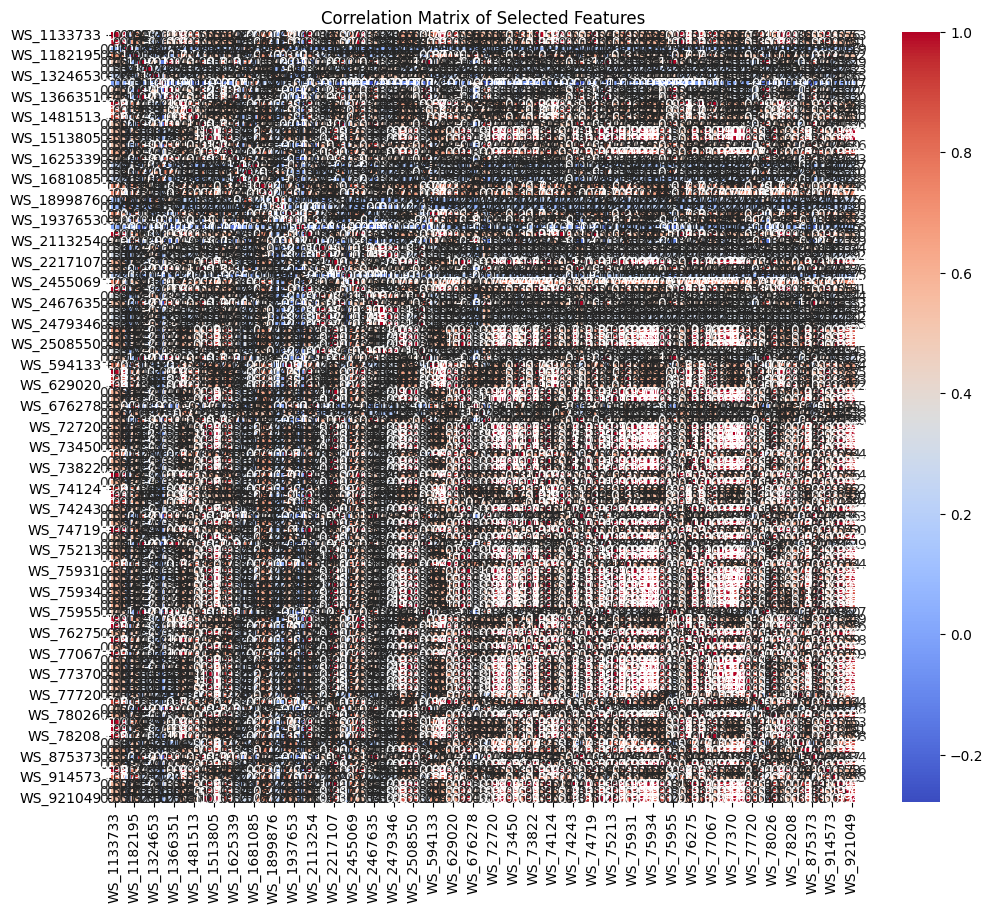

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

features_list = train_data.columns[2:]

# Create a dataframe with the consolidated features for multicollinearity analysis
features_df = train_data[features_list]

# Calculate the correlation matrix
correlation_matrix = features_df.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Selected Features')
plt.show()

In [4]:
# Remove features with correlation greater than 0.95
to_remove = set()
for i in range(len(correlation_matrix)):
    for j in range(i + 1, len(correlation_matrix)):
        if abs(correlation_matrix.iloc[i, j]) > 0.90:
            if train_data[correlation_matrix.columns[j]].corr(train_data['CF']) < train_data[correlation_matrix.columns[i]].corr(train_data['CF']):
                to_remove.add(correlation_matrix.columns[j])
                train_data[correlation_matrix.columns[j]+'_adj'] = train_data[correlation_matrix.columns[j]] - train_data[correlation_matrix.columns[i]]
            else:
                to_remove.add(correlation_matrix.columns[i])
                train_data[correlation_matrix.columns[i]+'_adj'] = train_data[correlation_matrix.columns[i]] - train_data[correlation_matrix.columns[j]]
                break

# Updated list of features after removing highly correlated ones
features_list = list(train_data.columns)
features_list.remove('CF')
features_list.remove('DATETIME')
features_after_removal = list(set(features_list) - to_remove)

len(features_after_removal), features_after_removal

(112,
 ['WS_1953863',
  'WS_2508550_adj',
  'WS_2455069',
  'WS_1574484_adj',
  'WS_2113254_adj',
  'WS_73450_adj',
  'WS_918665_adj',
  'WS_1461024_adj',
  'WS_74158_adj',
  'WS_75933_adj',
  'WS_74124_adj',
  'WS_914573',
  'WS_609612_adj',
  'WS_78207_adj',
  'WS_75812_adj',
  'WS_75932_adj',
  'WS_1513805_adj',
  'WS_76004_adj',
  'WS_883683_adj',
  'WS_1156770_adj',
  'WS_920775_adj',
  'WS_1820276_adj',
  'WS_76275_adj',
  'WS_77370_adj',
  'WS_1571308_adj',
  'WS_629008_adj',
  'WS_74884_adj',
  'WS_1481513',
  'WS_1513782_adj',
  'WS_1366351_adj',
  'WS_72721_adj',
  'WS_1820279',
  'WS_77067_adj',
  'WS_1937653_adj',
  'WS_1193865_adj',
  'WS_751132_adj',
  'WS_875373',
  'WS_1156968',
  'WS_2118117_adj',
  'WS_2586062',
  'WS_746023_adj',
  'WS_2385763',
  'WS_2503597',
  'WS_1937650_adj',
  'WS_77985_adj',
  'WS_1321569',
  'WS_2479346_adj',
  'WS_78205_adj',
  'WS_1182195_adj',
  'WS_1681085',
  'WS_1369320_adj',
  'WS_74243_adj',
  'WS_1911282',
  'WS_676403',
  'WS_72720_

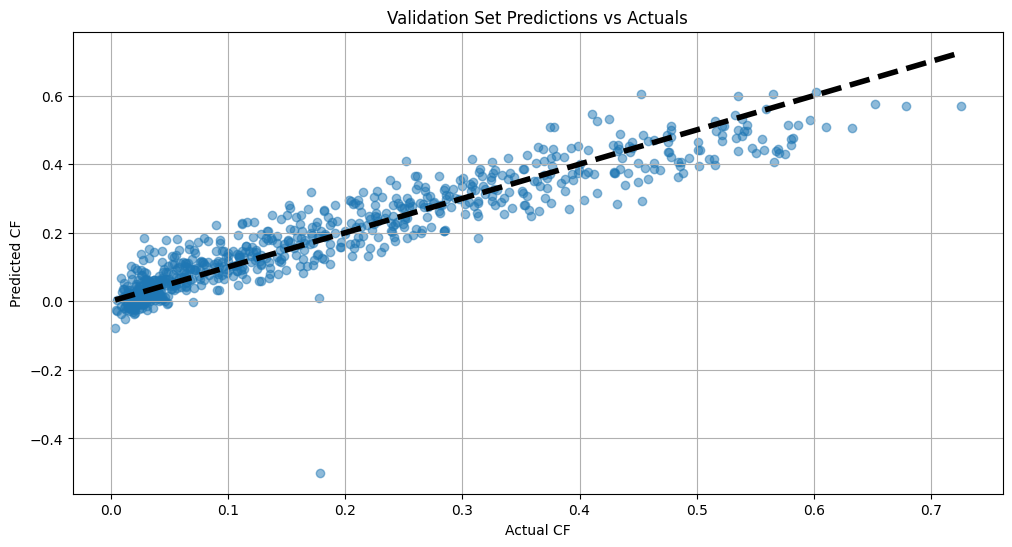

(0.04195755033305769, 0.04313870063238746, 0.0011811502993297682)

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import mlflow

mlflow.set_experiment('PowerPredict_ModelV1')

scaler = MinMaxScaler()


# Filter features based on a correlation threshold (|corr| > 0.5)

# correlations = train_data.drop(columns=['DATETIME']).corr()['CF'][features_after_removal].sort_values()
correlations = train_data.drop(columns=['DATETIME']).corr()['CF'][features_list].sort_values()

selected_features = correlations[correlations.abs() > 0.5].index.tolist()

# Prepare the data
X = train_data[selected_features]
y = train_data['CF']

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)


with mlflow.start_run():
      # Initialize and train the linear regression model
      linear_model = LinearRegression()
      linear_model.fit(X_train, y_train)

      # Predict on the traning set
      y_train_pred = linear_model.predict(X_train)

      # Predict on the validation set
      y_val_pred = linear_model.predict(X_val)

      # Calculate the MAE on the traning set
      mae_train = mean_absolute_error(y_train, y_train_pred)

      # Calculate the MAE on the validation set
      mae_val = mean_absolute_error(y_val, y_val_pred)
      
      mlflow.log_param("ModelType", 'BaseLine_Linear_CollinearityFeatureEngineering')
      mlflow.log_metric("mae_train", mae_train)
      mlflow.log_metric("mae_val", mae_val)

      mlflow.sklearn.log_model(linear_model, "BaseLineLinearModel")



# Visualizing predictions vs actuals for the validation set
plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)  # Perfect predictions line
plt.xlabel('Actual CF')
plt.ylabel('Predicted CF')
plt.title('Validation Set Predictions vs Actuals')
plt.grid(True)
plt.show()

mae_val, mae_train, mae_train-mae_val

Not huge improve but mae has decreased 0.007 for the baseline model

(I have tried to remove or combined feature who has high correlation, it makes the performance worse
And I tried to keep those features only have high relationship between target and features. Still doesn't work. This means every feature has siginificant information.
) 

### Extract useful information from low correclation features.

In [6]:
unselected_features = correlations[correlations.abs() < 0.5].index.tolist()

In [7]:
import numpy as np

scaler = MinMaxScaler()

X = train_data[unselected_features]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = scaler.fit(X_train)

train_data[unselected_features] = np.log(scaler.transform(train_data[unselected_features])+2)
train_data[unselected_features] = train_data[unselected_features].fillna(0)

In [8]:
features_list = list(train_data.columns)
features_list.remove('CF')
features_list.remove('DATETIME')
correlations = train_data.drop(columns=['DATETIME']).corr()['CF'][features_list].sort_values()

selected_features = correlations[correlations.abs() > 0.5].index.tolist()

In [9]:
from sklearn.decomposition import PCA


unselected_features = correlations[correlations.abs() < 0.5].index.tolist()

X = train_data[unselected_features]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

n_pca = int(len(unselected_features)*0.2)

pca = PCA(n_components=n_pca)
pca.fit(np.array(X_train))

transformed_pca_data = pca.transform(train_data[unselected_features])

for i in range(n_pca):
      train_data[f'PCA_{i}'] = transformed_pca_data[:,i]

c:\Users\a9529\Downloads\Vistra ML Project\.conda\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
C:\Users\a9529\AppData\Local\Temp\ipykernel_57796\1310132707.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[f'PCA_{i}'] = transformed_pca_data[:,i]
C:\Users\a9529\AppData\Local\Temp\ipykernel_57796\1310132707.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[f'PCA_{i}'] = transformed_pca_data[:,i]
C:\Users\a9529\AppData\

c:\Users\a9529\Downloads\Vistra ML Project\.conda\lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\a9529\Downloads\Vistra ML Project\.conda\lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


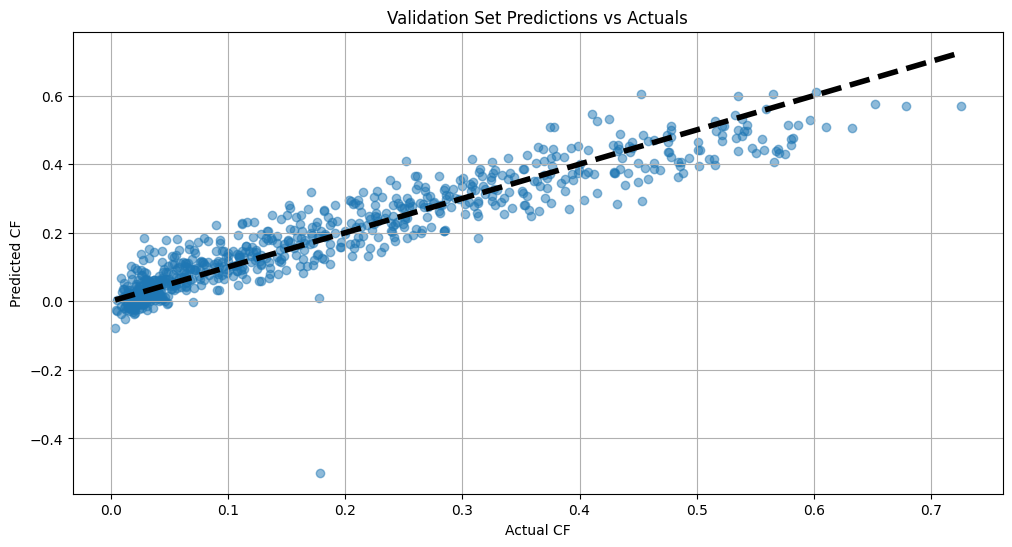

(0.04195755033305769, 0.04313870063238746, 0.0011811502993297682)

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
import mlflow

mlflow.set_experiment('PowerPredict_ModelV1')

scaler = MinMaxScaler()

# correlations = train_data.drop(columns=['DATETIME']).corr()['CF'][features_after_removal].sort_values()
correlations = train_data.drop(columns=['DATETIME']).corr()['CF'][features_list].sort_values()

selected_features = correlations[correlations.abs() > 0.5].index.tolist()

# Prepare the data
X = train_data[selected_features]
y = train_data['CF']

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
scaler = scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)


with mlflow.start_run():
      # Initialize and train the linear regression model
      linear_model = LinearRegression()
      linear_model.fit(X_train, y_train)

      # Predict on the traning set
      y_train_pred = linear_model.predict(X_train)

      # Predict on the validation set
      y_val_pred = linear_model.predict(X_val)

      # Calculate the MAE on the traning set
      mae_train = mean_absolute_error(y_train, y_train_pred)

      # Calculate the MAE on the validation set
      mae_val = mean_absolute_error(y_val, y_val_pred)
      
      mlflow.log_param("ModelType", 'BaseLine_Linear_CollinearityFeatureEngineering')
      mlflow.log_metric("mae_train", mae_train)
      mlflow.log_metric("mae_val", mae_val)

      mlflow.sklearn.log_model(linear_model, "BaseLineLinearModel")



# Visualizing predictions vs actuals for the validation set
plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_val_pred, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)  # Perfect predictions line
plt.xlabel('Actual CF')
plt.ylabel('Predicted CF')
plt.title('Validation Set Predictions vs Actuals')
plt.grid(True)
plt.show()

mae_val, mae_train, mae_train-mae_val

PCA Doesn't work very well at combining low correlation data

### leverage forward feature selection + backward feature selection.

c:\Users\a9529\Downloads\Vistra ML Project\.conda\lib\site-packages\_distutils_hack\__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\a9529\Downloads\Vistra ML Project\.conda\lib\site-packages\_distutils_hack\__init__.py:26: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


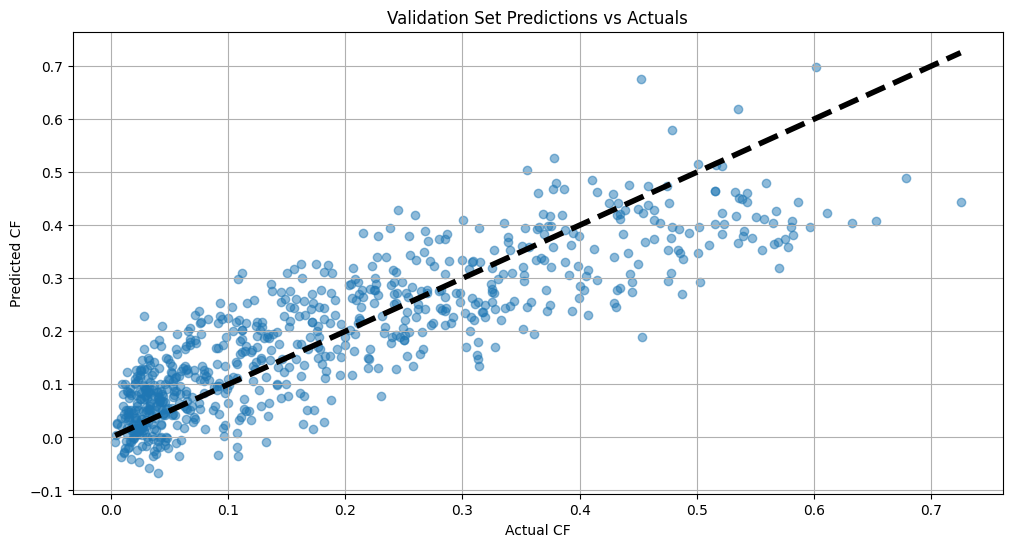

(['WS_73450_adj',
  'WS_811655_adj',
  'WS_594133_adj',
  'WS_75213_adj',
  'WS_1182195_adj',
  'WS_73451_adj',
  'WS_72720_adj',
  'WS_746023_adj',
  'WS_76275_adj',
  'WS_74180_adj',
  'WS_921049_adj',
  'WS_77985_adj',
  'WS_1628663',
  'WS_751132',
  'WS_1820276',
  'WS_1193865',
  'WS_77985',
  'WS_1461024',
  'WS_73451',
  'WS_1820279',
  'WS_1504146',
  'WS_77740',
  'WS_875373',
  'WS_74124',
  'WS_1481513',
  'WS_883699',
  'WS_74158',
  'WS_74719',
  'WS_1156770',
  'WS_76003',
  'WS_1960535',
  'WS_78205',
  'WS_76434',
  'WS_609612',
  'WS_76004',
  'WS_74020',
  'WS_921049',
  'WS_1513782',
  'WS_920775',
  'WS_2455069',
  'WS_77080',
  'WS_651000',
  'WS_1574484',
  'WS_78026',
  'WS_74243',
  'WS_76275',
  'WS_73450',
  'WS_73822',
  'WS_918665',
  'WS_746023',
  'WS_72733',
  'WS_75933',
  'WS_883683',
  'WS_73494',
  'WS_74022',
  'WS_2217107',
  'WS_631992',
  'WS_2503597'],
 0.041093726448355065)

In [12]:
from sklearn.feature_selection import SequentialFeatureSelector

# Set up the linearRegression
linear_model = LinearRegression()

# decrease the selection size
selected_features = correlations[correlations.abs() > 0.4].index.tolist()
X_train = X_train[selected_features]

# Implement forward feature selection
forward_selector = SequentialFeatureSelector(linear_model, n_features_to_select='auto', direction='forward', cv=5)
forward_selector.fit(X_train, y_train)

# Selected features based on forward selection
selected_features_forward = X_train.columns[forward_selector.get_support()].tolist()

with mlflow.start_run():

      # Train the Gradient Boosting model using the selected features
      linear_model.fit(X_train[selected_features_forward], y_train)

      # Predict on the validation set using the selected features
      y_train_pred_lr = linear_model.predict(X_train[selected_features_forward])

      # Predict on the validation set using the selected features
      y_val_pred_lr = linear_model.predict(X_val[selected_features_forward])

      # Calculate the MAE on the validation set
      mae_train_lr = mean_absolute_error(y_train, y_train_pred_lr)

      # Calculate the MAE on the validation set
      mae_val_lr = mean_absolute_error(y_val, y_val_pred_lr)

      mlflow.log_param("ModelType", 'BaseLine_Linear_ForwardSelection')
      mlflow.log_metric("mae_train", mae_train_lr)
      mlflow.log_metric("mae_val", mae_val_lr)

      mlflow.sklearn.log_model(linear_model, "BaseLineLinearModel")


# Visualizing predictions vs actuals for the validation set
plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_val_pred_gbr_rfe, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)  # Perfect predictions line
plt.xlabel('Actual CF')
plt.ylabel('Predicted CF')
plt.title('Validation Set Predictions vs Actuals')
plt.grid(True)
plt.show()

# Information on the model and results
selected_features_forward, mae_val_lr

forward selection doesn't work well

Overall, this dataset's most features have signifficant linear relationship. 
Only some features have nonlinear, that's why correlation is compared good method in selection. 

To Wrap features engineering's up:
1. Foward selection is better than Correlation Selection
2. Use log for the non-linear features


### Model Selection and Parameter Tuning

We will use the features selected by linear regression first to choose, then use the model we select to do the forward feature selection

In [13]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from tqdm import tqdm


# Define a dictionary of models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net': ElasticNet(),
    'Decision Tree Regressor': DecisionTreeRegressor(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'XGBoost Regressor': XGBRegressor(objective='reg:squarederror'),
    'LightGBM Regressor': LGBMRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'SVM Regressor': SVR(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'CatBoost': CatBoostRegressor()
}

# Evaluate each model using cross-validation
model_scores = {}
for name, model in tqdm(models.items()):
    # Using negative mean absolute error to align with cross_val_score convention
    scores = cross_val_score(model, X_train[selected_features_forward], y_train, scoring='neg_mean_absolute_error', cv=5)
    model_scores[name] = -scores.mean()  # Convert to positive MAE

model_scores

 58%|█████▊    | 7/12 [00:16<00:14,  2.93s/it]c:\Users\a9529\Downloads\Vistra ML Project\.conda\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\a9529\Downloads\Vistra ML Project\.conda\lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14790
[LightGBM] [Info] Number of data points in the train set: 2326, number of used features: 58
[LightGBM] [Info] Start training from score 0.185032
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14790
[LightGBM] [Info] Number of data points in the train set: 2326, number of used features: 58
[LightGBM] [Info] Start training from score 0.185840
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001479 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14790
[LightGBM] [Info] Number of data points in the train set: 2326, number of used features: 58
[LightGBM] [Info] Start tra

 67%|██████▋   | 8/12 [00:17<00:09,  2.39s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 14790
[LightGBM] [Info] Number of data points in the train set: 2327, number of used features: 58
[LightGBM] [Info] Start training from score 0.184231


 92%|█████████▏| 11/12 [01:07<00:09,  9.90s/it]

Learning rate set to 0.046785
0:	learn: 0.1588205	total: 137ms	remaining: 2m 17s
1:	learn: 0.1532247	total: 151ms	remaining: 1m 15s
2:	learn: 0.1477809	total: 153ms	remaining: 50.9s
3:	learn: 0.1426163	total: 156ms	remaining: 38.9s
4:	learn: 0.1378872	total: 159ms	remaining: 31.7s
5:	learn: 0.1333158	total: 162ms	remaining: 26.8s
6:	learn: 0.1288129	total: 164ms	remaining: 23.3s
7:	learn: 0.1246266	total: 167ms	remaining: 20.7s
8:	learn: 0.1206467	total: 169ms	remaining: 18.6s
9:	learn: 0.1167801	total: 172ms	remaining: 17s
10:	learn: 0.1131241	total: 174ms	remaining: 15.7s
11:	learn: 0.1098423	total: 177ms	remaining: 14.6s
12:	learn: 0.1065994	total: 180ms	remaining: 13.6s
13:	learn: 0.1035774	total: 183ms	remaining: 12.9s
14:	learn: 0.1006721	total: 185ms	remaining: 12.2s
15:	learn: 0.0978352	total: 188ms	remaining: 11.6s
16:	learn: 0.0952407	total: 191ms	remaining: 11s
17:	learn: 0.0925823	total: 193ms	remaining: 10.6s
18:	learn: 0.0902490	total: 196ms	remaining: 10.1s
19:	learn: 0.

100%|██████████| 12/12 [01:22<00:00,  6.91s/it]

982:	learn: 0.0123641	total: 2.79s	remaining: 48.2ms
983:	learn: 0.0123499	total: 2.79s	remaining: 45.4ms
984:	learn: 0.0123332	total: 2.8s	remaining: 42.6ms
985:	learn: 0.0123218	total: 2.8s	remaining: 39.8ms
986:	learn: 0.0123122	total: 2.8s	remaining: 36.9ms
987:	learn: 0.0123004	total: 2.81s	remaining: 34.1ms
988:	learn: 0.0122885	total: 2.81s	remaining: 31.2ms
989:	learn: 0.0122694	total: 2.81s	remaining: 28.4ms
990:	learn: 0.0122624	total: 2.81s	remaining: 25.6ms
991:	learn: 0.0122531	total: 2.82s	remaining: 22.7ms
992:	learn: 0.0122390	total: 2.82s	remaining: 19.9ms
993:	learn: 0.0122297	total: 2.82s	remaining: 17ms
994:	learn: 0.0122147	total: 2.83s	remaining: 14.2ms
995:	learn: 0.0122033	total: 2.83s	remaining: 11.4ms
996:	learn: 0.0121986	total: 2.83s	remaining: 8.52ms
997:	learn: 0.0121894	total: 2.83s	remaining: 5.68ms
998:	learn: 0.0121761	total: 2.84s	remaining: 2.84ms
999:	learn: 0.0121638	total: 2.84s	remaining: 0us


{'Linear Regression': 0.04460608562257597,
 'Ridge Regression': 0.046572160523793614,
 'Lasso Regression': 0.13907703606564287,
 'Elastic Net': 0.13907703606564287,
 'Decision Tree Regressor': 0.04505743889978091,
 'Gradient Boosting Regressor': 0.035935126789850766,
 'XGBoost Regressor': 0.0318423071020715,
 'LightGBM Regressor': 0.03057661547703671,
 'Random Forest Regressor': 0.032280334328676594,
 'SVM Regressor': 0.04781755943841316,
 'Gradient Boosting': 0.03595176783342375,
 'CatBoost': 0.028839650030583325}

Based on the result: CatBoost has the strongest performance.

Under boosting model: Catboost is the best

Under ensemble mode: Random forest is the best

Under Linear mode: Linear Regression is the best

SVM also has relative good performance

### Forward Feature Selection and Parameter Tunning for CatBoost

Use Catboost model to select features

In [14]:
from catboost import CatBoostRegressor, Pool, EShapCalcType, EFeaturesSelectionAlgorithm


# Prepare the data
X = train_data[features_list]
y = train_data['CF']

# Splitting the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
scaler = scaler.fit(X_train)
X_train.iloc[:,:] = scaler.transform(X_train)
X_val.iloc[:,:] = scaler.transform(X_val)

feature_names = X_train.columns.to_list()
train_pool = Pool(X_train, y_train, feature_names=feature_names)
test_pool = Pool(X_val, y_val, feature_names=feature_names)

model = CatBoostRegressor(iterations=1000, random_seed=0, task_type='GPU')
summary = model.select_features(
    train_pool,
    eval_set=test_pool,
    features_for_select='0-200',
    num_features_to_select=20,
    steps=3,
    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
    shap_calc_type=EShapCalcType.Regular,
    train_final_model=True,
    logging_level='Silent',
    plot=False
)


model = CatBoostRegressor(task_type='GPU')
selected_features_catboost_self = summary['selected_features_names']    
scores = cross_val_score(model, X_train[selected_features_catboost_self], y_train, scoring='neg_mean_absolute_error', cv=5)
-scores.mean()

Learning rate set to 0.045117
0:	learn: 0.1586351	total: 7.66ms	remaining: 7.65s
1:	learn: 0.1529565	total: 15.8ms	remaining: 7.89s
2:	learn: 0.1474194	total: 23.1ms	remaining: 7.68s
3:	learn: 0.1422322	total: 30.5ms	remaining: 7.6s
4:	learn: 0.1372772	total: 37.9ms	remaining: 7.55s
5:	learn: 0.1326063	total: 46.2ms	remaining: 7.65s
6:	learn: 0.1281124	total: 54.6ms	remaining: 7.74s
7:	learn: 0.1237824	total: 62ms	remaining: 7.68s
8:	learn: 0.1197153	total: 69.3ms	remaining: 7.63s
9:	learn: 0.1158496	total: 76.6ms	remaining: 7.58s
10:	learn: 0.1121480	total: 84.5ms	remaining: 7.59s
11:	learn: 0.1086466	total: 92.1ms	remaining: 7.58s
12:	learn: 0.1053506	total: 99.6ms	remaining: 7.56s
13:	learn: 0.1022483	total: 109ms	remaining: 7.69s
14:	learn: 0.0992670	total: 117ms	remaining: 7.66s
15:	learn: 0.0964445	total: 125ms	remaining: 7.66s
16:	learn: 0.0937693	total: 132ms	remaining: 7.64s
17:	learn: 0.0911903	total: 140ms	remaining: 7.63s
18:	learn: 0.0888123	total: 147ms	remaining: 7.61s
1

0.03420140844192221

Worse then Linear Regression as based model's Forward Selection

Use Forward Selection set catboost as based model to select features

In [15]:
# Set up the Gradient Boosting Regressor
catboost_model = CatBoostRegressor(iterations=80, random_seed=0, task_type='GPU')

# Implement forward feature selection
forward_selector = SequentialFeatureSelector(catboost_model, n_features_to_select='auto', direction='forward', cv=5)
forward_selector.fit(X_train, y_train)

# Selected features based on forward selection
selected_features_forward = X_train.columns[forward_selector.get_support()].tolist()

with mlflow.start_run():

      # Train the Gradient Boosting model using the selected features
      catboost_model.fit(X_train[selected_features_forward], y_train)

      # Predict on the validation set using the selected features
      y_train_pred_cat = catboost_model.predict(X_train[selected_features_forward])

      # Predict on the validation set using the selected features
      y_val_pred_cat = catboost_model.predict(X_val[selected_features_forward])

      # Calculate the MAE on the validation set
      mae_train_cat = mean_absolute_error(y_train, y_train_pred_cat)

      # Calculate the MAE on the validation set
      mae_val_cat = mean_absolute_error(y_val, y_val_pred_cat)

      mlflow.log_param("ModelType", 'Catboost_ForwardSelection')
      mlflow.log_metric("mae_train", mae_train_cat)
      mlflow.log_metric("mae_val", mae_val_cat)

      mlflow.sklearn.log_model(catboost_model, "CatboostModel")


plt.figure(figsize=(12, 6))
plt.scatter(y_val, y_val_pred_cat, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)  # Perfect predictions line
plt.xlabel('Actual CF')
plt.ylabel('Predicted CF')
plt.title('Validation Set Predictions vs Actuals')
plt.grid(True)
plt.show()

# Information on the model and results
mae_val_cat, mae_train_cat

Learning rate set to 0.203795
0:	learn: 0.1475519	total: 2.83ms	remaining: 224ms
1:	learn: 0.1352107	total: 4.82ms	remaining: 188ms
2:	learn: 0.1266877	total: 7.03ms	remaining: 180ms
3:	learn: 0.1209408	total: 9.18ms	remaining: 174ms
4:	learn: 0.1170444	total: 11.2ms	remaining: 167ms
5:	learn: 0.1144750	total: 13.1ms	remaining: 161ms
6:	learn: 0.1127611	total: 15.5ms	remaining: 162ms
7:	learn: 0.1116447	total: 17.6ms	remaining: 159ms
8:	learn: 0.1109010	total: 19.7ms	remaining: 155ms
9:	learn: 0.1103719	total: 21.7ms	remaining: 152ms
10:	learn: 0.1100091	total: 24.1ms	remaining: 151ms
11:	learn: 0.1097348	total: 26.4ms	remaining: 150ms
12:	learn: 0.1095405	total: 28.5ms	remaining: 147ms
13:	learn: 0.1094256	total: 30.5ms	remaining: 144ms
14:	learn: 0.1093166	total: 33.2ms	remaining: 144ms
15:	learn: 0.1092255	total: 35.1ms	remaining: 141ms
16:	learn: 0.1091560	total: 37.2ms	remaining: 138ms
17:	learn: 0.1090965	total: 39.5ms	remaining: 136ms
18:	learn: 0.1090539	total: 41.8ms	remaining

KeyboardInterrupt: 